# Box Office Movie Franchise Predictor - EDA

Perform some Exploratory Data Analysis on the collected and cleaned data

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import plotly.express as px
import plotly.graph_objects as go

%config InlineBackend.figure_format='retina'

## Load Data File(s)

In [2]:
data_path = './data/'

file_all = 'movies_with_sequels_final_cleaned.csv'
file_org = 'movies_with_originals_only_final_cleaned.csv'
file_seq = 'movies_with_sequels_only_final_cleaned.csv'

df_all = pd.read_csv(data_path + file_all)
df_org = pd.read_csv(data_path + file_org)
df_seq = pd.read_csv(data_path + file_seq)

In [3]:
df_all['Release Date'] = pd.to_datetime(df_all['Release Date'])
df_org['Release Date'] = pd.to_datetime(df_org['Release Date'])
df_seq['Release Date'] = pd.to_datetime(df_seq['Release Date'])

In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            1078 non-null   object        
 1   url              1078 non-null   object        
 2   IMDB Score       1078 non-null   float64       
 3   Metacritic       973 non-null    float64       
 4   Runtime (mins)   1078 non-null   int64         
 5   Budget           1078 non-null   float64       
 6   Opening Weekend  952 non-null    float64       
 7   Gross USA        1005 non-null   float64       
 8   Gross World      1078 non-null   float64       
 9   Release Date     1078 non-null   datetime64[ns]
 10  Rating           1078 non-null   object        
 11  Genres           1078 non-null   object        
 12  Country          1078 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 109.6+ KB


In [5]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            539 non-null    object        
 1   url              539 non-null    object        
 2   IMDB Score       539 non-null    float64       
 3   Metacritic       505 non-null    float64       
 4   Runtime (mins)   539 non-null    int64         
 5   Budget           539 non-null    float64       
 6   Opening Weekend  475 non-null    float64       
 7   Gross USA        508 non-null    float64       
 8   Gross World      539 non-null    float64       
 9   Release Date     539 non-null    datetime64[ns]
 10  Rating           539 non-null    object        
 11  Genres           539 non-null    object        
 12  Country          539 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 54.9+ KB


In [6]:
df_seq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            539 non-null    object        
 1   url              539 non-null    object        
 2   IMDB Score       539 non-null    float64       
 3   Metacritic       468 non-null    float64       
 4   Runtime (mins)   539 non-null    int64         
 5   Budget           539 non-null    float64       
 6   Opening Weekend  477 non-null    float64       
 7   Gross USA        497 non-null    float64       
 8   Gross World      539 non-null    float64       
 9   Release Date     539 non-null    datetime64[ns]
 10  Rating           539 non-null    object        
 11  Genres           539 non-null    object        
 12  Country          539 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 54.9+ KB


In [7]:
df_all['Rating'].unique()

array(['PG-13', 'R', 'PG', 'G'], dtype=object)

In [8]:
df_all['Genres'].nunique()

167

In [9]:
# Let's check and see if there are any negative deltas between original and sequel
def diff_rel_dates(data_org,data_seq,delta_type):
    
    df_diff = (data_seq['Release Date'] - data_org['Release Date'])/np.timedelta64(1, delta_type)
    
    neg_diff = df_diff[df_diff < 0]
    
    if neg_diff is not None:
        print('No negative difference')
    else:
        print('There are negative time(s) between sequel and original. Please check!')

    return df_diff

# Some EDA

## World Wide Gross (Sequel vs. Original)

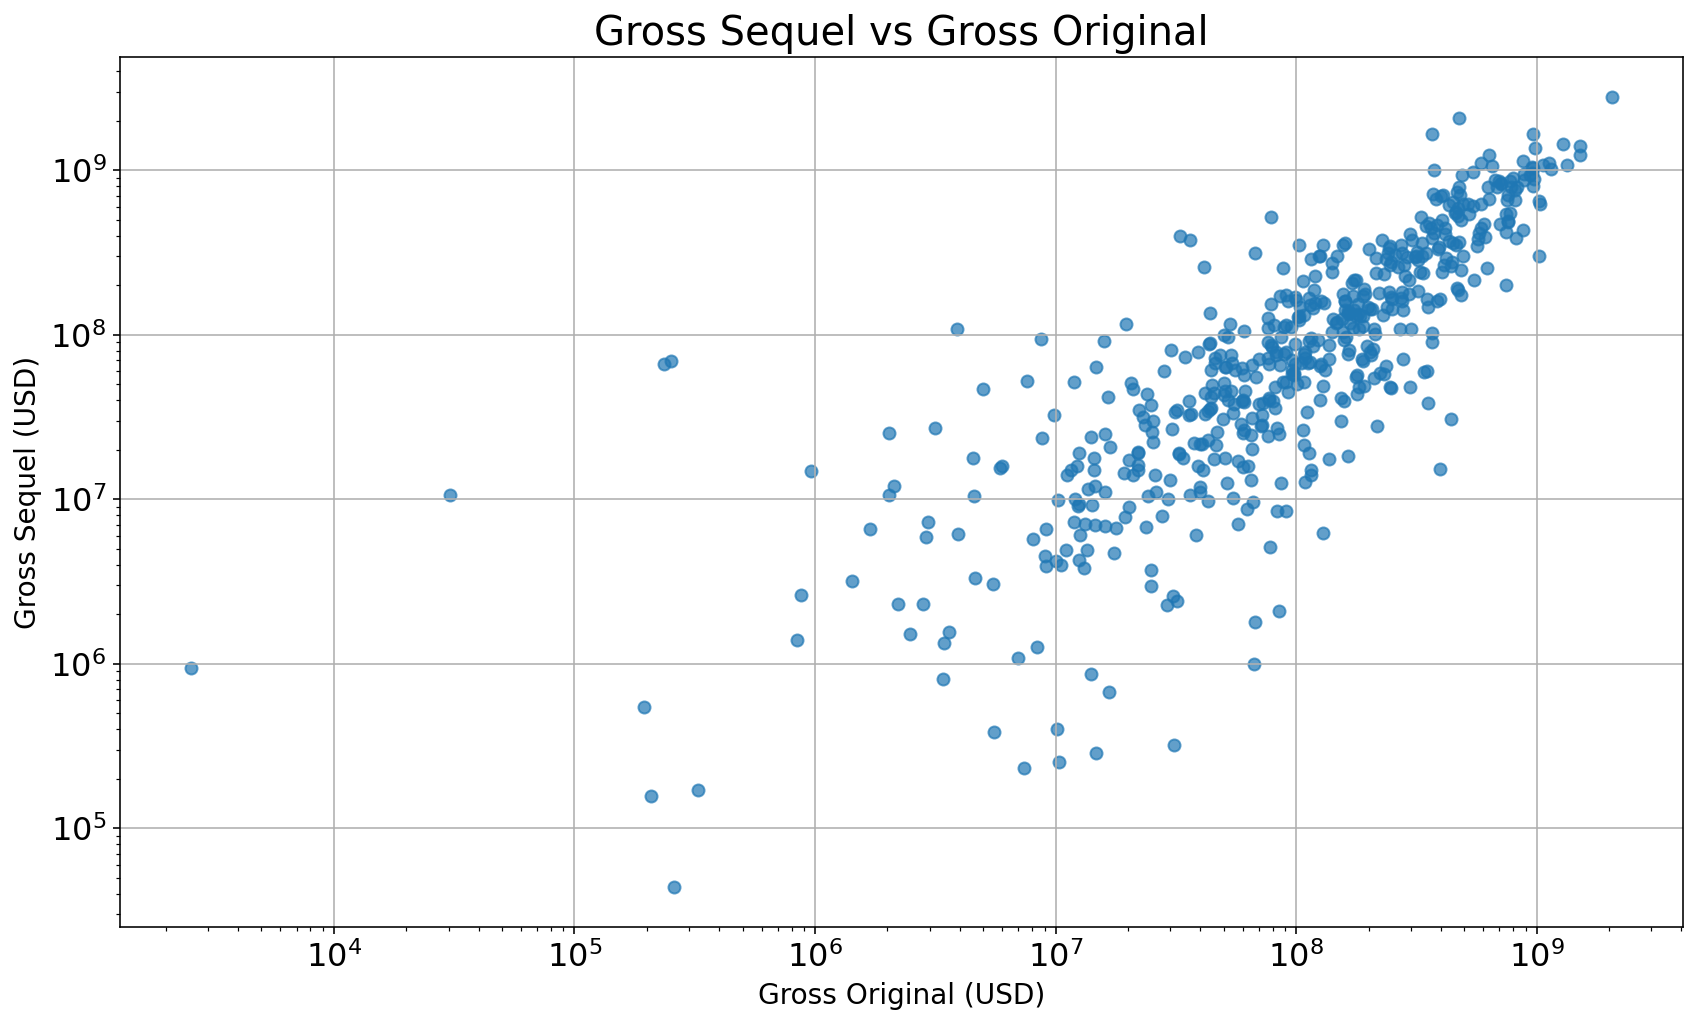

In [10]:
# Let's check the correlation between box office returns between the original and its sequel

gross_org = df_org['Gross World']
gross_seq = df_seq['Gross World']

plt.figure(figsize=(14,8))
#plt.scatter(np.log10(gross),np.log10(gross_seq),alpha=0.5);
plt.scatter(gross_org,gross_seq,alpha=0.7);
plt.xscale('log')
plt.yscale('log')
plt.title('Gross Sequel vs Gross Original',fontsize=20);
plt.xlabel('Gross Original (USD)', fontsize=14);
plt.ylabel('Gross Sequel (USD)', fontsize=14);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./images/gross_sequel_vs_original.svg')
plt.grid()

From the figure above, the log scale plot is nearly linear when comparing between the gross original and sequel. Hence, Linear Regression is a good starting point when modeling. The linearity is stronger if the original gross is above USD 10 Million below that, the spread is larger. Let's take a look at which movies are giving the spread.

In [11]:
# Create a dataframe for plotly
df_temp1 = pd.DataFrame()
df_temp1['Title Org. || Seq.']  = df_org['Title'] + " || " + df_seq['Title']

df_temp1['Gross Original'] = df_org['Gross World']
df_temp1['Gross Sequel']   = df_seq['Gross World']

df_temp1['Budget Original'] = df_org['Budget']
df_temp1['Budget Sequel']   = df_seq['Budget']

df_temp1['IMDB Score Original'] = df_org['IMDB Score']
df_temp1['IMDB Score Sequel']   = df_seq['IMDB Score']

# Let's take the average
df_temp1['Avg IMDB Score'] = round((df_org['IMDB Score'] + df_seq['IMDB Score'])/2,2)
df_temp1['Log(Avg Gross)'] = round(np.log((df_org['Gross World'] + df_seq['Gross World'])/2),2)

df_temp1.head()

Title Org. || Seq.  Gross Original  \
0           Spider-Man (2002) || Spider-Man 2 (2004)    8.250250e+08   
1    The Matrix (1999) || The Matrix Reloaded (2003)    4.653438e+08   
2  The Lord of the Rings: The Fellowship of the R...    8.878328e+08   
3  The Lord of the Rings: The Return of the King ...    1.142219e+09   
4  The Hobbit: The Desolation of Smaug (2013) || ...    9.583669e+08   

   Gross Sequel  Budget Original  Budget Sequel  IMDB Score Original  \
0  7.889765e+08      139000000.0    200000000.0                  7.3   
1  7.418465e+08       63000000.0    150000000.0                  8.7   
2  9.512081e+08       93000000.0     94000000.0                  8.8   
3  1.017004e+09       94000000.0    180000000.0                  8.9   
4  9.560198e+08      225000000.0    250000000.0                  7.8   

   IMDB Score Sequel  Avg IMDB Score  Log(Avg Gross)  
0                7.3            7.30           20.51  
1                7.2            7.95           20.22  
2                8.7            8.75           20.64  
3                7.8            8.35           20.80  
4                7.4            7.60           20.68

In [12]:
fig = px.scatter(df_temp1, x="Gross Original", y="Gross Sequel", hover_data = ['Title Org. || Seq.'], 
                 log_x=True,log_y=True, opacity=0.8, width=1000, height=600, color='Log(Avg Gross)')

fig.update_layout(
    title={
        'text': "Gross Sequel vs Gross Original",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Gross Original (USD)",
    yaxis_title="Gross Sequel (USD)")

fig.update_traces(marker=dict(size=8,
                              line=dict(width=1)),
                  selector=dict(mode='markers'))

#fig.write_image("./images/gross_sequel_vs_original_plotly.svg")
fig.show()

## Budgets

### All Movie Budgets vs. Gross Return

In [13]:
fig1 = px.scatter(df_all, x="Budget", y="Gross World", hover_data = ['Title'], 
                 log_x=True,log_y=True, opacity=0.8, width=1000, height=600, color='Rating')

fig1.update_layout(
    title={
        'text': "World Wide Gross vs Budget, All Movies",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Budget (USD)",
    yaxis_title="World Wide Gross (USD)")

fig1.update_traces(marker=dict(size=8,
                              line=dict(width=1)),
                  selector=dict(mode='markers'))

#fig.write_image("./images/gross_sequel_vs_original_plotly.svg")
fig1.show()

### World Wide Gross vs IMDB Score

In [14]:
fig2 = px.scatter(df_all, x="IMDB Score", y="Gross World", hover_data = ['Title'], 
                 log_x=False,log_y=True, opacity=0.8, width=1000, height=600, color='Rating')

fig2.update_layout(
    title={
        'text': "World Wide Gross vs IMDB Score",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="IMDB Score",
    yaxis_title="World Wide Gross (USD)")

fig2.update_traces(marker=dict(size=8,
                              line=dict(width=1)),
                  selector=dict(mode='markers'))

#fig.write_image("./images/gross_sequel_vs_original_plotly.svg")
fig2.show()

In [15]:
fig3 = px.scatter(df_temp1, x="IMDB Score Original", y="IMDB Score Sequel", hover_data = ['Title Org. || Seq.'], 
                 log_x=False,log_y=False, opacity=0.8, width=1000, height=600, color='Avg IMDB Score')

fig3.update_layout(
    title={
        'text': "IMDB Scores, Sequel vs. Original",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="IMDB Score Original",
    yaxis_title="IMDB Score Sequel")

fig3.update_traces(marker=dict(size=8,
                              line=dict(width=1)),
                  selector=dict(mode='markers'))

#fig3.write_image("./images/gross_sequel_vs_original_plotly.svg")
fig3.show()

### World Wide Gross vs Budget (Rating)

In [16]:
fig4 = px.scatter(df_all, x="Budget", y="Gross World", hover_data = ['Title'], 
                 log_x=True,log_y=True, opacity=0.8, width=1000, height=600, color='Rating')

fig4.update_layout(
    title={
        'text': "Gross World Wide vs Budget (All Movies)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Budget [USD]",
    yaxis_title="Gross World Wide [USD]")

fig4.update_traces(marker=dict(size=8,
                              line=dict(width=1)),
                  selector=dict(mode='markers'))

#fig3.write_image("./images/gross_sequel_vs_original_plotly.svg")
fig4.show()

## Ratings Count

In [17]:
from collections import Counter

rating_counter = Counter(df_all['Rating'])

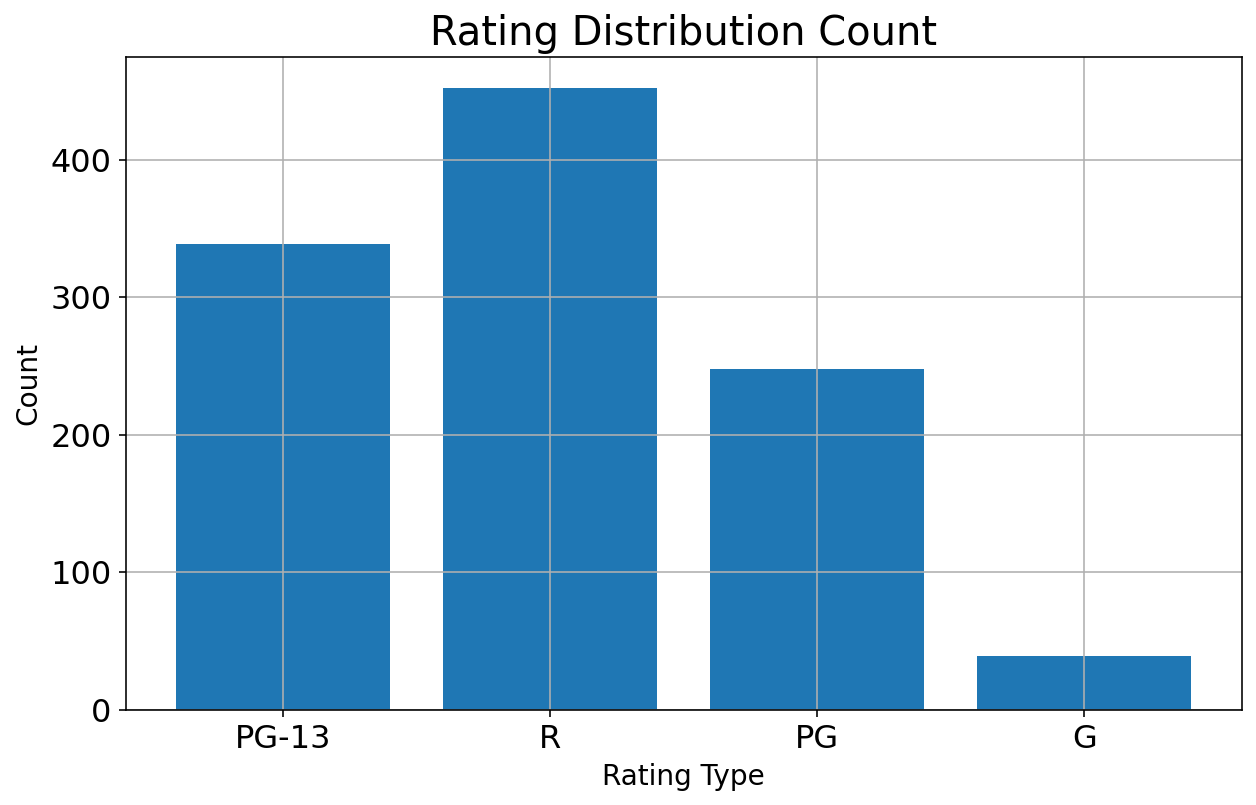

In [18]:
plt.figure(figsize=(10,6))
plt.bar(rating_counter.keys(), rating_counter.values())
plt.title('Rating Distribution Count',fontsize=20);
plt.xlabel('Rating Type', fontsize=14);
plt.ylabel('Count', fontsize=14);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./images/bar_plot_rating_dist.svg')
plt.grid()

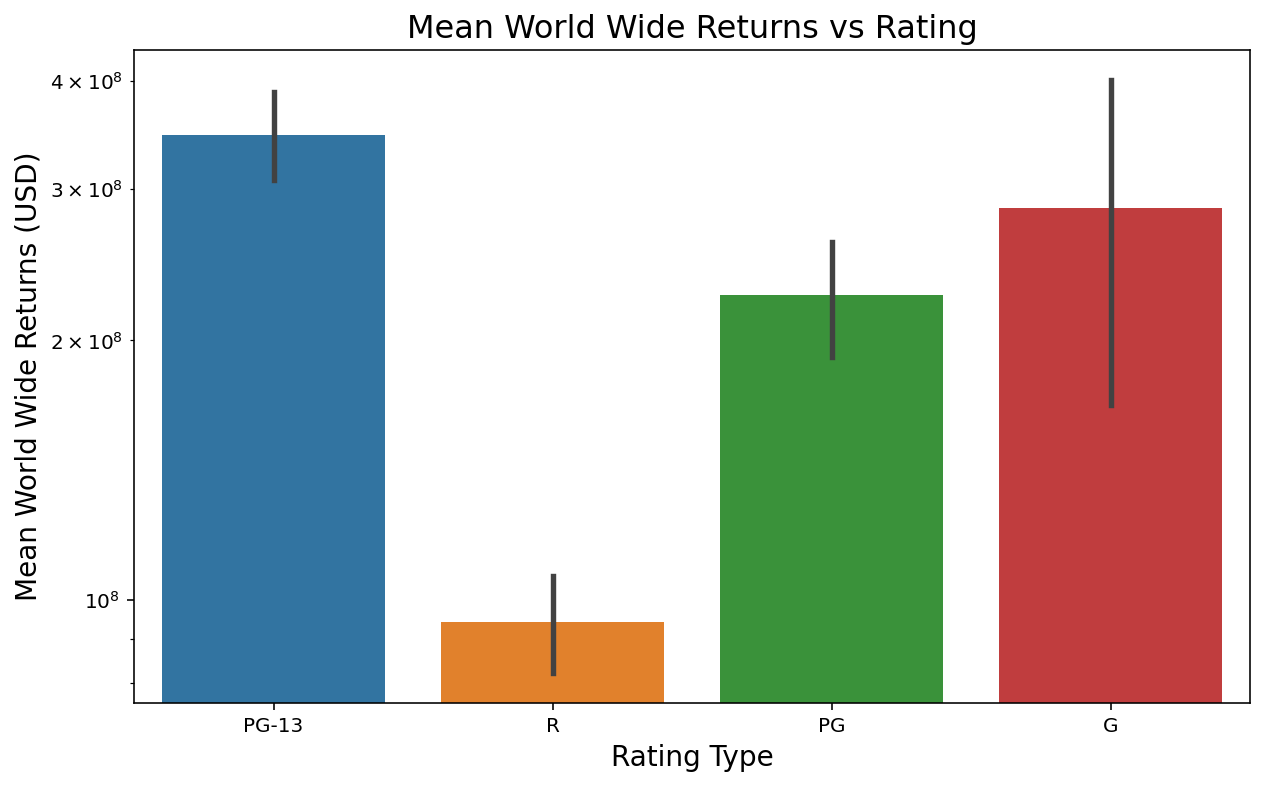

In [19]:
group = df_all[['Gross World','Rating']].groupby('Rating').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.barplot(x='Rating', y='Gross World', data=df_all, ax=ax);
ax.set_xlabel('Rating Type',fontsize=14)
ax.set_ylabel('Mean World Wide Returns (USD)',fontsize=14)
ax.set_title('Mean World Wide Returns vs Rating', fontsize=16)
ax.set_yscale('log')
#plt.tight_layout()
plt.show();
fig.savefig('./images/mean_returns_per_rating.svg')

In [20]:
fig5 = px.histogram(df_all, x="Gross World",log_y=False,log_x=False,nbins=60,histnorm='percent',color='Rating')

fig5.update_layout(
    title={
        'text': "Gross World Distribution",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Gross Bins (USD)",
    yaxis_title="Percent")
fig5.show()

In [21]:
fig9 = px.histogram(df_all, x="Gross World",log_y=False,log_x=False,nbins=100,cumulative=True,histnorm='percent'
                    ,color='Rating')

fig9.update_layout(
    title={
        'text': "Gross World Cumulative (Originals and Sequels)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Gross Bins (USD)",
    yaxis_title="Percent")
fig9.show()

## Temporal Specific

In [22]:
# Pick difference
diff_type = 'Y'

diff_time = diff_rel_dates(df_org,df_seq,diff_type)

No negative difference


In [23]:
# Add delta between months sequel release month and day of week
df_temp1['Diff Years'] = round(diff_time,2)

df_temp1['ReleaseDay'] = df_seq['Release Date'].dt.dayofweek
df_temp1['ReleaseDayName'] = df_seq['Release Date'].dt.day_name()
df_temp1['ReleaseMonth'] = df_seq['Release Date'].dt.month

#df_temp1.head()

In [24]:
# For entire dataset
df_all['ReleaseDay']     = df_all['Release Date'].dt.dayofweek
df_all['ReleaseDayName'] = df_all['Release Date'].dt.day_name()
df_all['ReleaseMonth']   = df_all['Release Date'].dt.month

In [25]:
# Get percent deltas between sequel and original
df_temp1['GrossPercentDiff'] = round(((df_seq['Gross World'] - df_org['Gross World'])/df_org['Gross World'])*100,2)

#df_temp1.GrossPercentDiff

In [26]:
fig6 = px.scatter(df_temp1, x="Diff Years", y="Gross Sequel", hover_data = ['Title Org. || Seq.'], 
                  log_x=True,log_y=True, opacity=0.8, width=1000, height=600, color='Log(Avg Gross)')

fig6.update_layout(
    title={
        'text': "Gross Sequel vs Years Between Release",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        xaxis_title="Years between Release",
        yaxis_title="Gross Sequel [USD]")

fig6.update_traces(marker=dict(size=8,
                              line=dict(width=1)),
                  selector=dict(mode='markers'))

#fig3.write_image("./images/gross_sequel_vs_original_plotly.svg")
fig6.show()

In [27]:
fig7 = px.histogram(df_temp1, x="Diff Years",log_y=False,log_x=False,nbins=100, histnorm='percent')

fig7.update_layout(
    title={
        'text': "Years Between Sequel and Original",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Number of Years between Release",
    yaxis_title="Percent")
fig7.show()

In [28]:
fig9 = px.histogram(df_temp1, x="Diff Years",log_y=False,log_x=False, cumulative=True, histnorm='percent', nbins=100)

fig9.update_layout(
    title={
        'text': "Years Between Sequel and Original (Cumulative)",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Number of Years between Release bins",
    yaxis_title="Percentage")
fig9.show()

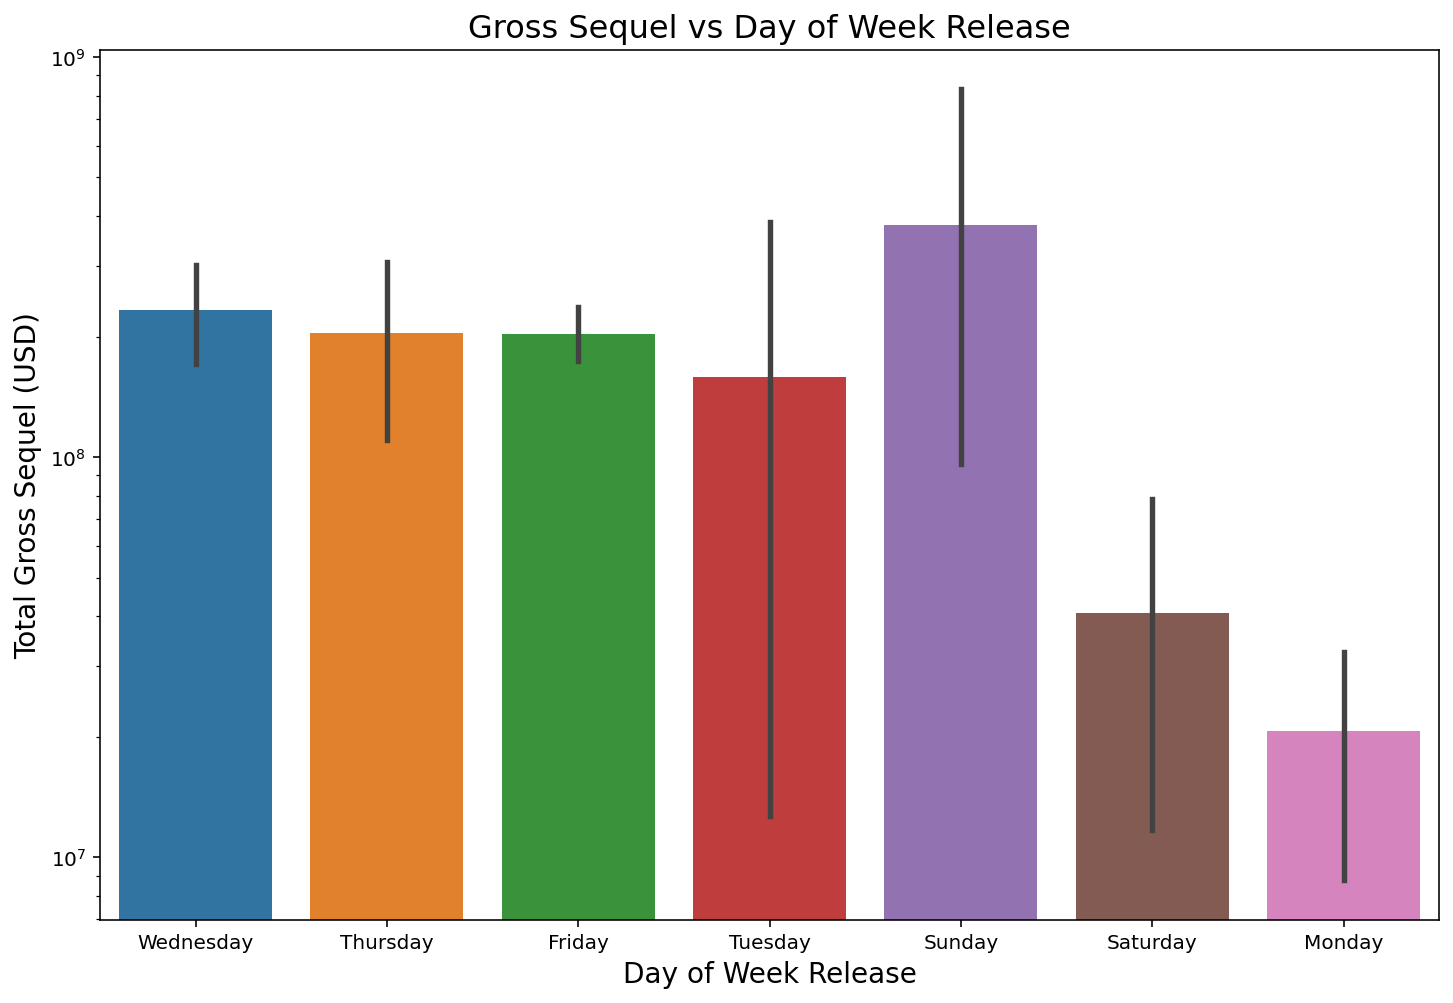

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

sns.barplot(x='ReleaseDayName', y='Gross Sequel', data=df_temp1, ax=ax);
ax.set_xlabel('Day of Week Release',fontsize=14)
ax.set_ylabel('Total Gross Sequel (USD)',fontsize=14)
ax.set_title('Gross Sequel vs Day of Week Release', fontsize=16)
ax.set_yscale('log')
#plt.tight_layout()
plt.show();
fig.savefig('./images/Gross_Sequel_DayofWeek.svg')

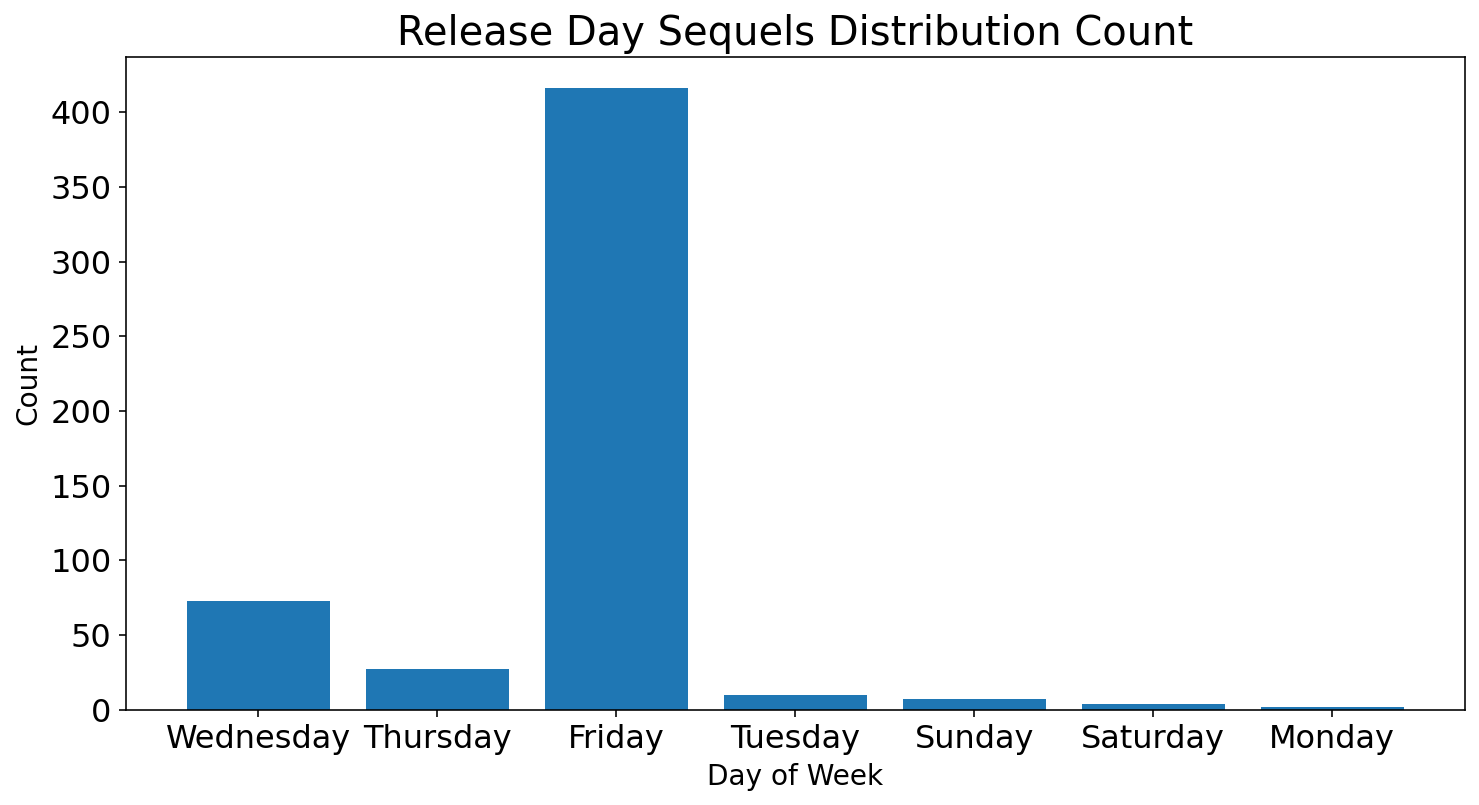

In [30]:
rel_day_counter = Counter(df_temp1['ReleaseDayName'])

plt.figure(figsize=(12,6))
plt.bar(rel_day_counter.keys(), rel_day_counter.values())
plt.title('Release Day Sequels Distribution Count',fontsize=20);
plt.xlabel('Day of Week', fontsize=14);
plt.ylabel('Count', fontsize=14);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('./images/bar_plot_rel_day_name_seq_dist.svg')
#plt.grid()

'''
group1 = df_temp1[['Gross Sequel','ReleaseDayName']].groupby('ReleaseDayName').mean()

group1.reset_index(level=['ReleaseDayName'], inplace=True)

ax = group1.plot(kind='bar', figsize=(12,8), fontsize=13, logy=True);
ax.set_alpha(0.8)
ax.set_title("Mean Sequel Gross vs Day of Week Release", fontsize=18)
ax.set_ylabel("Mean Sequel Gross", fontsize=12);
plt.show()
fig.savefig('./images/Mean_Gross_Sequel_DayofWeek.svg')
''';

In [31]:
fig8 = px.scatter(df_temp1, x="Diff Years", y="GrossPercentDiff", hover_data = ['Title Org. || Seq.'], 
                  log_x=True,log_y=True, opacity=0.8, width=1000, height=600, color='Log(Avg Gross)')

fig8.update_layout(
    title={
        'text': "Percent Difference Gross Seq-Org vs Years Between Release",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        xaxis_title="Years between Release",
        yaxis_title="Percent Difference in Gross World Wide")

fig8.update_traces(marker=dict(size=8,
                              line=dict(width=1)),
                  selector=dict(mode='markers'))

#fig3.write_image("./images/gross_sequel_vs_original_plotly.svg")
fig8.show()

In [32]:
fig8 = px.scatter(df_temp1, x="Diff Years", y="GrossPercentDiff", hover_data = ['Title Org. || Seq.'], 
                  log_x=True,log_y=False, opacity=0.8, width=1000, height=600, color='Log(Avg Gross)')

fig8.update_layout(
        title={
        'text': "Percent Difference Gross Seq-Org vs Years Between Release",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        xaxis_title="Years between Release",
        yaxis_title="Percent Difference in Gross World Wide",
        yaxis=dict(range=[-200,0]))

fig8.update_traces(marker=dict(size=8,
                              line=dict(width=1)),
                  selector=dict(mode='markers'))

#fig3.write_image("./images/gross_sequel_vs_original_plotly.svg")
fig8.show()

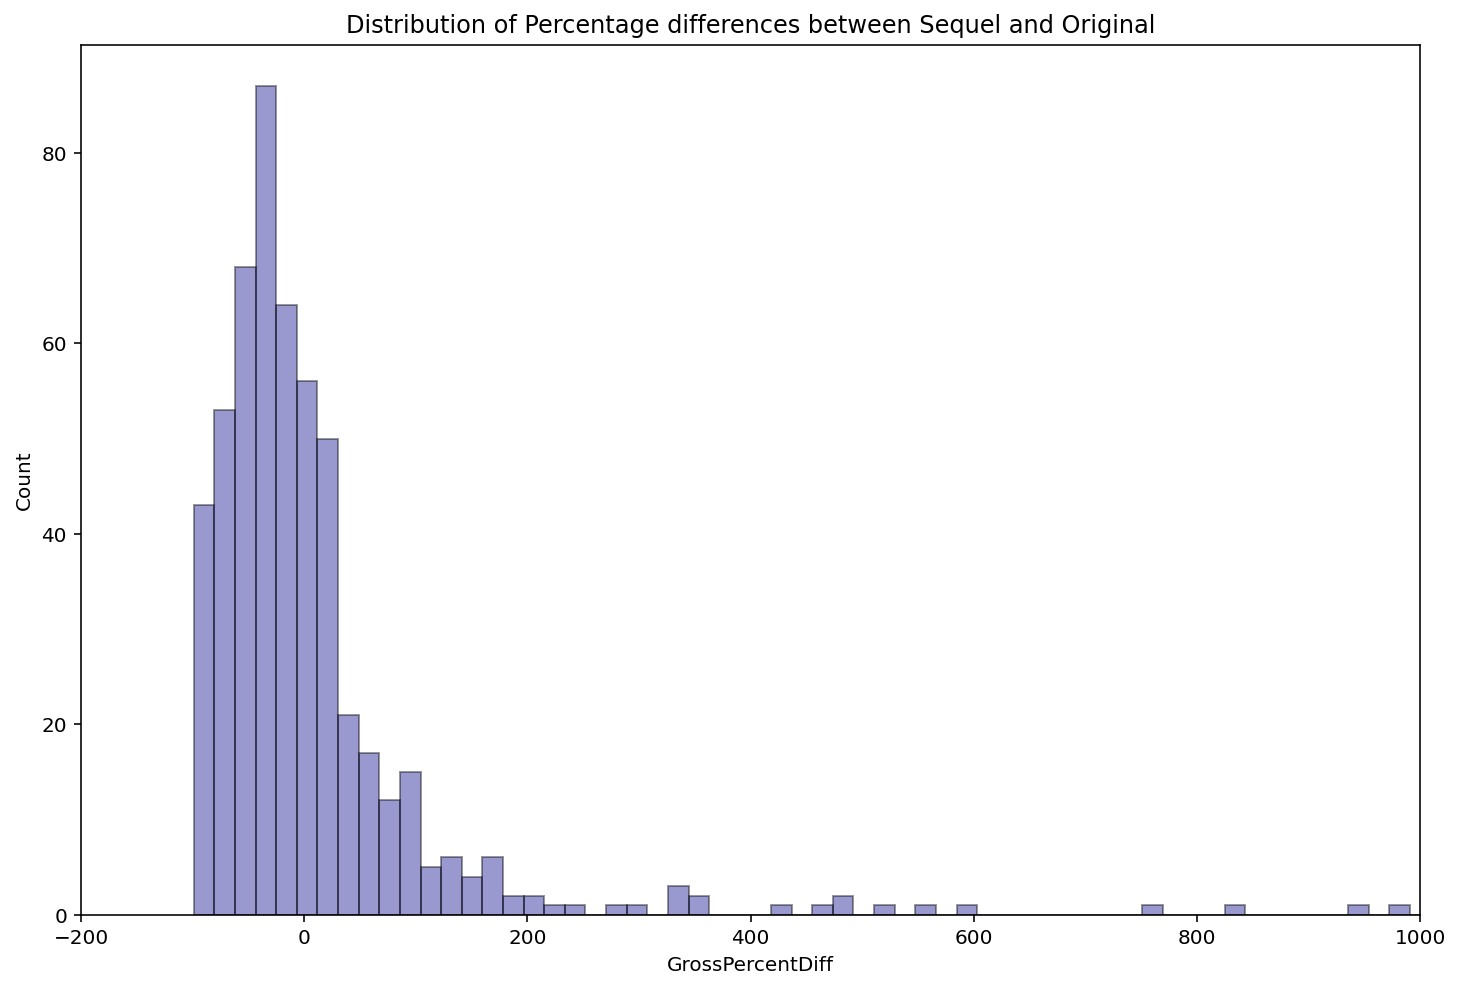

In [33]:
# Look at percent difference

percent_diff = df_temp1['GrossPercentDiff']

plt.figure(figsize=(12,8))
sns.distplot(percent_diff, hist=True, kde=False, 
             bins=2000, color = 'darkblue',
             hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})

plt.title('Distribution of Percentage differences between Sequel and Original')
plt.ylabel('Count')
plt.axis([-200, 1000, None, None]);
plt.savefig('./images/Distribution_gross_pct_difference.svg')

## Genre

In [34]:

def get_genres(data):
    
    genres = []
    
    for item in data:
        
        item = item.strip()
        item = item.split()
        
        for item2 in item:
            genres.extend(item)
        
    genres_dict = Counter(genres)
    
    return genres_dict


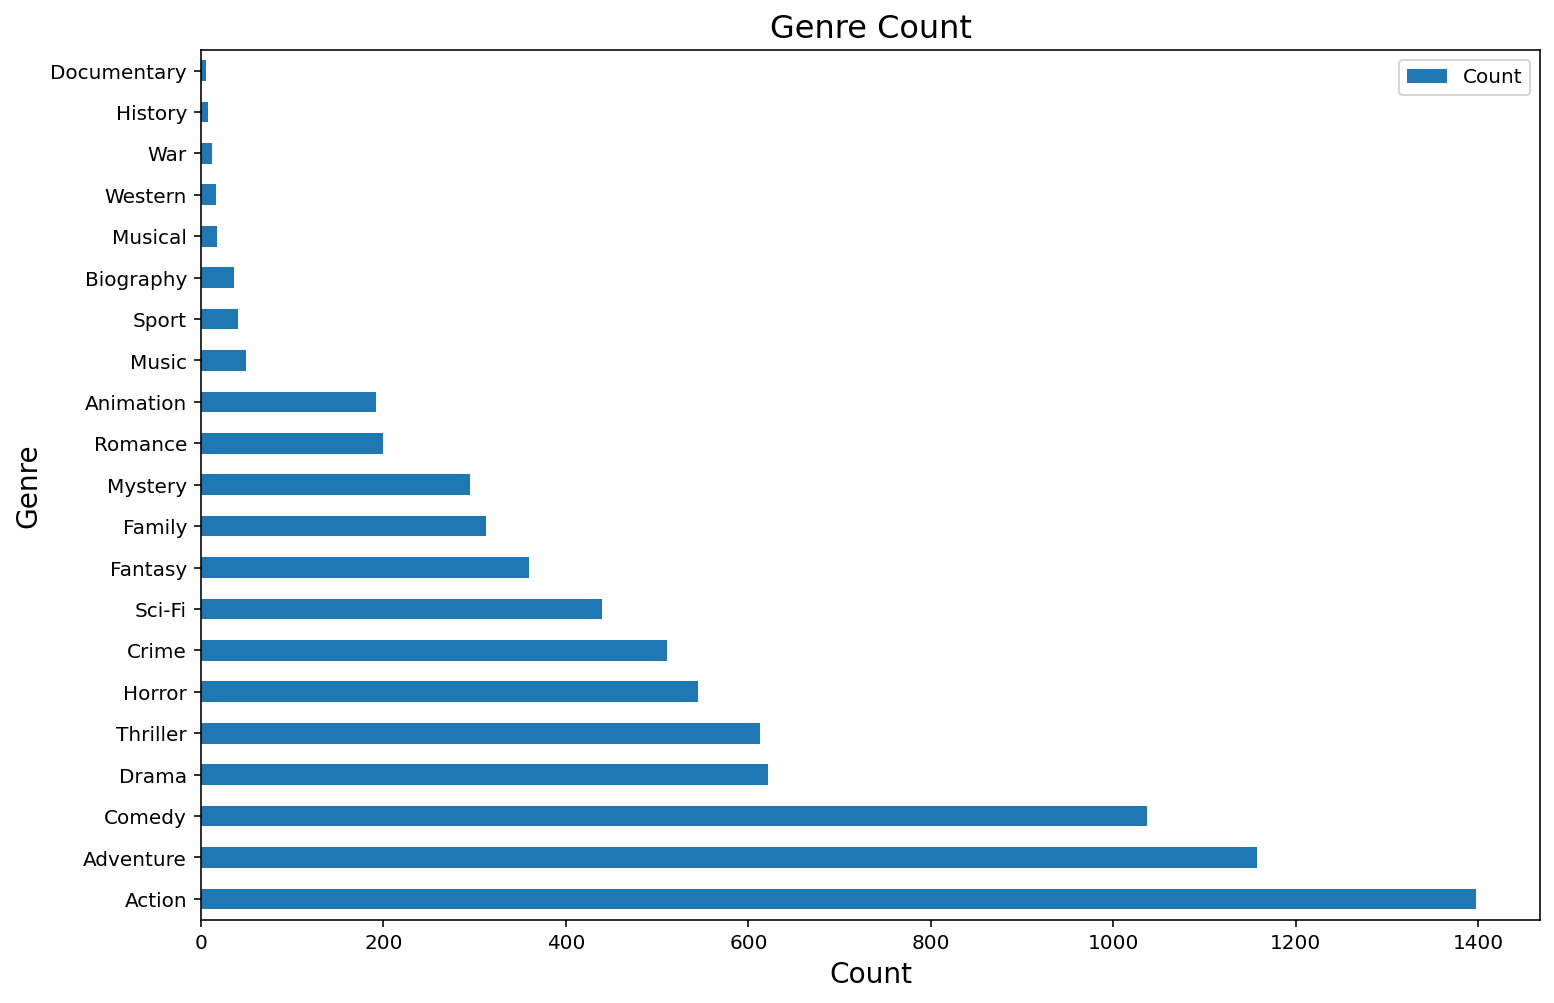

In [35]:
#genres = df_all['Genres'][0].apply(get_genres) #get_genres(df_all['Genres'])

genres_dict_count = get_genres(list(df_all['Genres']))
    
df_genres_dict_count = pd.DataFrame.from_dict(genres_dict_count,orient='index').reset_index()

df_genres_dict_count = df_genres_dict_count.rename(columns={'index':'Genre', 0:'Count'}).sort_values(by='Count',ascending=False)

df_genres_dict_count = df_genres_dict_count.set_index('Genre')
#pd.DataFrame.from_dict(d, orient='index').reset_index()

fig = df_genres_dict_count.plot(kind='barh',figsize=(12,8))
fig.set_xlabel('Count',fontsize=14)
fig.set_ylabel('Genre',fontsize=14)
fig.set_title('Genre Count',fontsize=16);
plt.savefig('./images/bar_plot_genre_all.svg')

## Country

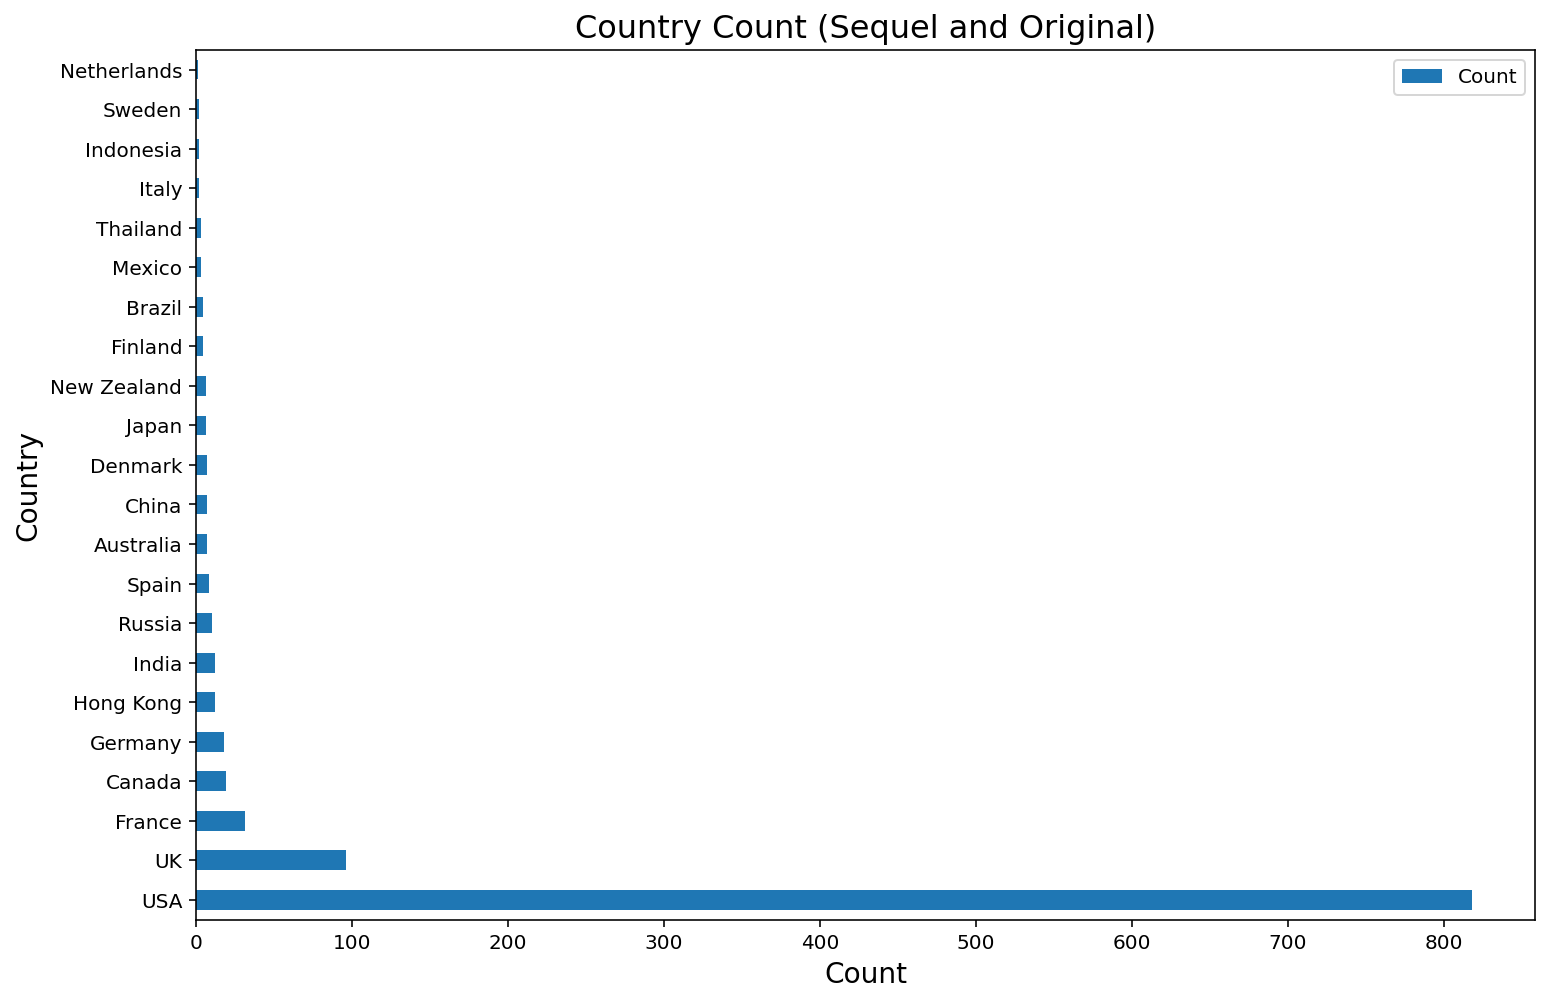

In [40]:
country_counter = Counter(df_all['Country'])

df_country_count = pd.DataFrame.from_dict(country_counter,orient='index').reset_index()

df_country_count = df_country_count.rename(columns={'index':'Country', 0:'Count'}).sort_values(by='Count',ascending=False)

df_country_count = df_country_count.set_index('Country')


fig = df_country_count.plot(kind='barh',figsize=(12,8))
fig.set_xlabel('Count',fontsize=14)
fig.set_ylabel('Country',fontsize=14)
fig.set_title('Country Count (Sequel and Original)',fontsize=16);
plt.savefig('./images/bar_plot_country_all.svg')


'''
plt.figure(figsize=(12,6))
plt.barh(country_counter.keys(), country_counter.values())
plt.title('Country Count, Originals and Sequels',fontsize=20);
plt.xlabel('Country', fontsize=14);
plt.ylabel('Count', fontsize=14);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./images/country_bar_plot.svg')
''';

# Comments

Based on the data:

1. Sequels that are released on Sundays on average receives the highest return. This will seem counter-intuitive as most movies are now released on Thursdays and Fridays. Note the count plot for Friday is highly favorable thus skewing the distribution.


2. No clear correlation between percent delta of gross sequel and original versus months between release.


3. Nearly 60% of movie sequels are released between 0 to 40 months (Slightly more than 3 years) from the original.


4. Almost linear correlation between gross of sequel and original, gross of movie and its budget.


5. Based on the gross cumulative chart categorized by rating, there is a higher return if the movie is rated R.


6. Top three genres are Comedy, Adventure and Action. They appear to win by a wide margin.